In [1]:
# Imports
import pandas as pd
import numpy as np
import datetime
from datetime import time as dtime
from datetime import timedelta
from datetime import date
import matplotlib as plt
from itertools import product
import openpyxl

# importing historical data for backtest
def get1minBars(csvName):
    
    priceData1minBars_df = pd.read_csv(csvName, usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
    
    # Parse datetime column and divide in 2 columns
    # SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
    priceData1minBars_df.rename(columns={
        'date': 'datetime'
    }, inplace=True)
    
    priceData1minBars_df['datetime'] = pd.to_datetime(priceData1minBars_df['datetime'])
    
    priceData1minBars_df['Date'] = priceData1minBars_df['datetime'].dt.date
    priceData1minBars_df['Time'] = priceData1minBars_df['datetime'].dt.time
    
    # sorting the data by the time column to make sure it is consistent
    priceData1minBars_df.sort_values('datetime', inplace=True)
    
    # Drop original 'date' column
    # SPY_Data.drop(columns=['date'], inplace=True)
    
    # Filter for regular trading hours using datetime column
    # priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time >= pd.to_datetime("09:30").time()]
    # priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time <= pd.to_datetime("16:00").time()]
    
    # Making sure the order of the columns stays the same 
    priceData1minBars_df = priceData1minBars_df[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
    
    return priceData1minBars_df
    
    


In [2]:
NQ_Data = get1minBars('NQ_1min_master.csv')
# QQQ_Data = QQQ_Data[472980:483000]
NQ_Data = NQ_Data[:int(len(NQ_Data)/2)]
NQ_Data

,Date,Time,open,high,low,close,volume
0,2023-11-01,22:00:00,14761.25,14763.50,14760.00,14760.00,175
1,2023-11-01,22:01:00,14760.50,14764.00,14760.50,14762.00,156
2,2023-11-01,22:02:00,14762.25,14762.25,14760.50,14761.25,48
3,2023-11-01,22:03:00,14761.25,14762.00,14760.75,14761.00,30
4,2023-11-01,22:04:00,14761.75,14763.00,14761.00,14762.25,52
...,...,...,...,...,...,...,...
353281,2024-10-31,15:47:00,20059.50,20060.00,20042.25,20047.50,2006
353282,2024-10-31,15:48:00,20047.50,20052.00,20035.75,20042.75,2235
353283,2024-10-31,15:49:00,20042.50,20044.75,20036.25,20040.25,1373
353284,2024-10-31,15:50:00,20040.25,20046.75,20034.00,20040.00,1524


In [3]:
import pandas as pd
import numpy as np
from datetime import time as dtime

def backtest_noon_breakout_boundary_toggle(df):
    """
    Boundary-toggles with a 2pm shutdown rule.

    Per day:
      • Build 12:00–13:00 range [low, high].
      • After 13:00, enter next-bar open on close outside the range.
      • Exit next-bar open when close returns inside the range.
      • If that boundary re-entry happens at/after 14:00, exit and STOP trading for the day.
      • If still in a position at session end, exit at last close.

    Returns (trades_df, stats) with entry/exit *times*.
    """
    data = df.copy(deep=True)
    data[['open','high','low','close']] = data[['open','high','low','close']].astype(float)

    # Normalize Time to datetime.time
    def _as_time(x):
        if isinstance(x, pd.Timestamp): return x.time()
        if isinstance(x, str):
            parts = [int(t) for t in x.split(':')]
            while len(parts) < 3: parts.append(0)
            return dtime(parts[0], parts[1], parts[2])
        return x

    data['Time'] = data['Time'].apply(_as_time)

    trades = []

    for date, g in data.groupby('Date', sort=False):
        g = g.reset_index(drop=True)

        # 12:00–13:00 boundary
        mask_range = (g['Time'] >= dtime(12, 0)) & (g['Time'] <= dtime(13, 0))
        if not mask_range.any():
            continue

        range_high = g.loc[mask_range, 'high'].max()
        range_low  = g.loc[mask_range, 'low'].min()

        # After 13:00 act on closes, trade next-bar open
        mask_after_noon = (g['Time'] > dtime(13, 0))
        idxs = np.where(mask_after_noon)[0]
        if len(idxs) == 0:
            continue

        in_pos = False
        side = None
        entry_idx = None
        entry_price = None
        entry_time = None
        done_for_day = False  # set True if boundary is re-entered at/after 14:00

        i = idxs[0]
        while i < len(g):
            if done_for_day:
                break  # stop any further activity for the day

            close_i = g.at[i, 'close']
            time_i  = g.at[i, 'Time']

            def _enter(next_i, new_side):
                nonlocal in_pos, side, entry_idx, entry_price, entry_time
                if next_i >= len(g):
                    return False
                in_pos = True
                side = new_side
                entry_idx = next_i
                entry_price = g.at[next_i, 'open']
                entry_time = g.at[next_i, 'Time']
                return True

            def _exit(next_i, reason):
                nonlocal in_pos, side, entry_idx, entry_price, entry_time, done_for_day
                if next_i >= len(g):
                    exit_idx = len(g) - 1
                    exit_price = g.at[exit_idx, 'close']
                    exit_time = g.at[exit_idx, 'Time']
                else:
                    exit_idx = next_i
                    exit_price = g.at[exit_idx, 'open']
                    exit_time = g.at[exit_idx, 'Time']

                pnl = (exit_price - entry_price) if side == 'long' else (entry_price - exit_price)

                trades.append({
                    'date': date,
                    'side': side,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'range_high': range_high,
                    'range_low': range_low,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'reason': reason,
                    'pnl_points': pnl
                })

                in_pos = False
                side = None
                entry_idx = None
                entry_price = None
                entry_time = None

            if not in_pos:
                # Enter on breakouts outside the boundary
                if close_i > range_high:
                    if not _enter(i + 1, 'long'):
                        break
                    i = entry_idx
                    continue
                elif close_i < range_low:
                    if not _enter(i + 1, 'short'):
                        break
                    i = entry_idx
                    continue
            else:
                # Exit when price CLOSES back inside the boundary
                if range_low <= close_i <= range_high:
                    after_two_pm = (time_i >= dtime(16, 00))
                    _exit(i + 1, 'reenter_boundary_after_2pm' if after_two_pm else 'reenter_boundary')
                    if after_two_pm:
                        done_for_day = True
                        break  # stop trading for the rest of the day

            i += 1

        # Day-end exit if still in position
        if in_pos and not done_for_day:
            exit_idx = len(g) - 1
            exit_price = g.at[exit_idx, 'close']
            exit_time = g.at[exit_idx, 'Time']
            pnl = (exit_price - entry_price) if side == 'long' else (entry_price - exit_price)
            trades.append({
                'date': date,
                'side': side,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'range_high': range_high,
                'range_low': range_low,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'reason': 'session_close',
                'pnl_points': pnl
            })

    trades_df = pd.DataFrame(trades)

    # Stats
    if trades_df.empty:
        stats = pd.Series(dtype=float)
    else:
        dt_entry = pd.to_datetime(trades_df['date'].astype(str) + ' ' + trades_df['entry_time'].astype(str))
        dt_exit  = pd.to_datetime(trades_df['date'].astype(str) + ' ' + trades_df['exit_time'].astype(str))
        hold_minutes = (dt_exit - dt_entry).dt.total_seconds() / 60.0

        stats = pd.Series({
            'n_trades': len(trades_df),
            'win_rate': (trades_df['pnl_points'] > 0).mean(),
            'avg_pnl_points': trades_df['pnl_points'].mean(),
            'total_pnl_points': trades_df['pnl_points'].sum(),
            'median_hold_minutes': float(np.median(hold_minutes))
        })

    return trades_df, stats


In [4]:
trades, stats = backtest_noon_breakout_boundary_toggle(NQ_Data)
print(stats)
trades['range_width'] = trades['range_high'] - trades['range_low']
trades = trades[~((trades['side'] == 'short') & ((trades['range_low'] - trades['entry_price']) > 35) | (trades['side'] == 'long') & ((trades['range_high'] - trades['entry_price']) > 35))]

print(trades['pnl_points'].sum())
trades

n_trades               1613.000000
win_rate                  0.072536
avg_pnl_points            1.808122
total_pnl_points       2916.500000
median_hold_minutes       4.000000
dtype: float64
3256.0


,date,side,entry_time,exit_time,range_high,range_low,entry_price,exit_price,reason,pnl_points,range_width
0,2023-11-02,long,14:52:00,15:02:00,14953.5,14871.0,14956.75,14945.25,reenter_boundary,-11.50,82.5
1,2023-11-02,long,15:04:00,15:12:00,14953.5,14871.0,14962.25,14952.00,reenter_boundary,-10.25,82.5
2,2023-11-02,long,15:13:00,15:15:00,14953.5,14871.0,14961.00,14946.50,reenter_boundary,-14.50,82.5
3,2023-11-02,long,15:18:00,15:19:00,14953.5,14871.0,14954.75,14952.75,reenter_boundary,-2.00,82.5
4,2023-11-02,long,15:20:00,15:23:00,14953.5,14871.0,14954.75,14949.25,reenter_boundary,-5.50,82.5
...,...,...,...,...,...,...,...,...,...,...,...
1608,2024-10-30,short,15:34:00,15:41:00,20734.5,20670.0,20657.00,20670.00,reenter_boundary,-13.00,64.5
1609,2024-10-30,short,15:42:00,15:44:00,20734.5,20670.0,20658.50,20673.25,reenter_boundary,-14.75,64.5
1610,2024-10-30,short,15:47:00,15:49:00,20734.5,20670.0,20667.00,20671.00,reenter_boundary,-4.00,64.5
1611,2024-10-30,short,16:01:00,16:02:00,20734.5,20670.0,20667.75,20671.00,reenter_boundary_after_2pm,-3.25,64.5


n_trades                 1605.000000
win_rate                    0.072409
avg_win                   156.144397
avg_loss                   -9.997813
payoff_ratio               15.617855
expectancy_per_trade        2.032459
gross_profit            18112.750000
gross_loss              14856.750000
profit_factor               1.219160
total_pnl                3256.000000
median_pnl                 -7.000000
max_drawdown            -1015.750000
sharpe_per_trade            1.431120
dtype: float64


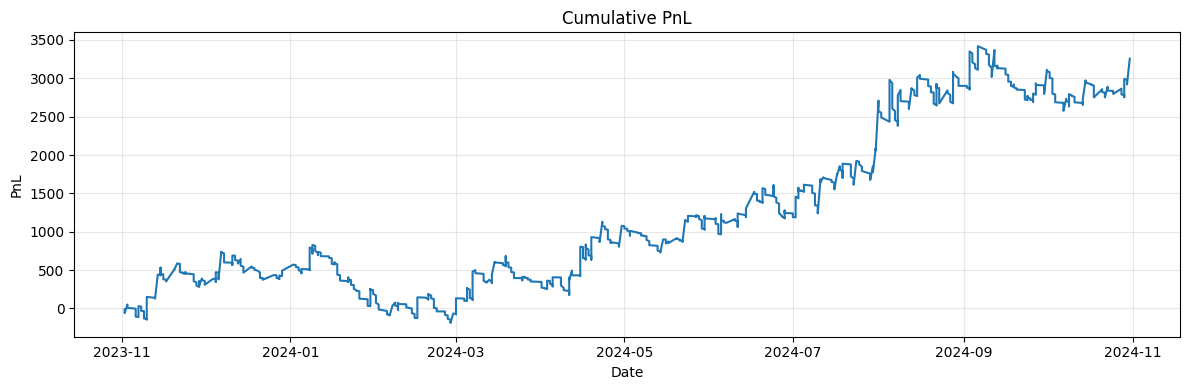

,date,side,entry_time,exit_time,range_high,range_low,entry_price,exit_price,reason,pnl_points,range_width,Date
0,2023-11-02,long,14:52:00,15:02:00,14953.5,14871.0,14956.75,14945.25,reenter_boundary,-11.50,82.5,2023-11-02
1,2023-11-02,long,15:04:00,15:12:00,14953.5,14871.0,14962.25,14952.00,reenter_boundary,-10.25,82.5,2023-11-02
2,2023-11-02,long,15:13:00,15:15:00,14953.5,14871.0,14961.00,14946.50,reenter_boundary,-14.50,82.5,2023-11-02
3,2023-11-02,long,15:18:00,15:19:00,14953.5,14871.0,14954.75,14952.75,reenter_boundary,-2.00,82.5,2023-11-02
4,2023-11-02,long,15:20:00,15:23:00,14953.5,14871.0,14954.75,14949.25,reenter_boundary,-5.50,82.5,2023-11-02
...,...,...,...,...,...,...,...,...,...,...,...,...
1608,2024-10-30,short,15:34:00,15:41:00,20734.5,20670.0,20657.00,20670.00,reenter_boundary,-13.00,64.5,2024-10-30
1609,2024-10-30,short,15:42:00,15:44:00,20734.5,20670.0,20658.50,20673.25,reenter_boundary,-14.75,64.5,2024-10-30
1610,2024-10-30,short,15:47:00,15:49:00,20734.5,20670.0,20667.00,20671.00,reenter_boundary,-4.00,64.5,2024-10-30
1611,2024-10-30,short,16:01:00,16:02:00,20734.5,20670.0,20667.75,20671.00,reenter_boundary_after_2pm,-3.25,64.5,2024-10-30


In [6]:

def trade_stats(df, pnl_col='returns', r_col=None, equity_start=0.0):
    """
    df must have a PnL column (default: 'returns').
    If you also have an R-multiple column, pass its name via r_col.
    Returns (stats_dict, equity_series, drawdown_series).
    """
    # sort (optional, helps equity curve look right)
    if {'Date','timeExit'}.issubset(df.columns):
        df = df.sort_values(['Date','timeExit'])
    s = pd.Series(df[pnl_col].astype(float).values)
    n = int(s.size)
    if n == 0:
        return {}, pd.Series(dtype=float), pd.Series(dtype=float)

    wins   = s[s > 0]
    losses = s[s < 0]

    gross_profit = float(wins.sum())
    gross_loss   = float(-losses.sum())  # positive number

    win_rate  = float(len(wins) / (len(wins) + len(losses)))
    loss_rate = float(len(losses) / (len(wins) + len(losses)))

    avg_win  = float(wins.mean())   if len(wins)   else 0.0
    avg_loss = float(losses.mean()) if len(losses) else 0.0  # negative
    payoff   = (avg_win / abs(avg_loss)) if len(wins) and len(losses) else np.inf

    profit_factor = (gross_profit / gross_loss) if gross_loss > 0 else np.inf
    expectancy    = win_rate * avg_win + loss_rate * avg_loss  # per trade

    equity = pd.Series(equity_start + s.cumsum(), name='equity')
    run_max = equity.cummax()
    drawdown = equity - run_max
    max_dd = float(drawdown.min())  # negative

    std = float(s.std(ddof=1))
    sharpe_per_trade = (float(s.mean() - 0.04) / std * np.sqrt(n)) if std > 0 and n > 1 else np.nan

    stats = {
        'n_trades': n,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,                 # negative number
        'payoff_ratio': payoff,               # |avg_win| / |avg_loss|
        'expectancy_per_trade': expectancy,   # same units as returns
        'gross_profit': gross_profit,
        'gross_loss': gross_loss,
        'profit_factor': profit_factor,
        'total_pnl': float(s.sum()),
        'median_pnl': float(s.median()),
        'max_drawdown': max_dd,               # same units as returns
        'sharpe_per_trade': sharpe_per_trade
    }

    if r_col and r_col in df.columns:
        r = df[r_col].astype(float)
        stats.update({
            'avg_R': float(r.mean()),
            'median_R': float(r.median()),
            'total_R': float(r.sum()),
            'win_rate_Rpos': float((r > 0).mean())
        })

    return stats #, equity, drawdown


stats = trade_stats(trades, pnl_col='pnl_points')
print(pd.Series(stats))




temp = trades.copy(deep=True)

if 'date' in temp.columns:
    temp['Date'] = pd.to_datetime(temp['date'], errors='coerce')
    df = temp.sort_values('date')

r = pd.to_numeric(df['pnl_points'], errors='coerce').fillna(0)

# 1) Cumulative PnL (use for per-trade PnL/points)
df['cum_pnl'] = r.cumsum()


import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df['Date'] if 'Date' in df.columns else df.index, df['cum_pnl'])
plt.title('Cumulative PnL')
plt.xlabel('Date' if 'Date' in df.columns else 'Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

temp